# This cell has two classes:
1. `EnvChannel`: Defines the environment
2. `ControlAgent`: Defines the control agent

# Parameters:
1. ```alpha```: Learning rate of agent
2. `gamma`: Discount factor
3. `epsilon`: for epsilon-greedy policy
4. `num_states`: Number of states in system, currently three(Good, Medium, Bad)
5. `d1`: Delay threshold for Good state and medium state
6. `d2`: Delay threshold for Medium and bad state

# Arguments:
1. `state_list`: List of integer states. 
2. `avg_confidence`: (Float) Average confidence 
    
# Sample use:

```
agent = ControlAgent(d1=10,d2=20)
agent.get_signal(delay_list, avg_confidence)
```
# To Do:
1. ~~Instead of taking state_list directly, estimate the states indirectly from packet delay.~~ **Done**
2. ~~Update the function get_delay_factor.~~ **Done** 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle

class EnvChannel:
    def __init__(self, num_states=3):
        
        self.num_states = num_states
        self.states = np.arange(self.num_states)
        self.curr_state = np.random.choice(self.states)
        self.prev_state = -1
        self.reward = 0
        self.action = 0
        self.num_actions = 3 # Up, Down, No change
        
    def sample_action(self):
        return np.random.choice(self.num_actions)
    
    def step(self, action, partial_reward, state_diff):
        self.action = action
        self.reward = - np.exp(np.abs(state_diff)**2) + partial_reward
        return self.reward
    
        
    def reset(self):
        self.__init__(num_states=self.num_states)
        return self.curr_state
   

class ControlAgent:
    def __init__(self, d1, d2, alpha=0.1, gamma=.99, epsilon=.95, num_states=3):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.env = EnvChannel(num_states)
        self.q_table = np.zeros([self.env.num_states, self.env.num_actions])
        self.all_epochs = []
        self.penalties = 0
        self.iteration_i = 0
        self.prev_state = None
        self.d1 = d1
        self.d2 = d2
        self.avg_delay = 0
        self.prev_avg_delay = 0

        
    def get_delay_factor(self):
        # This should be function of delay
#         return np.average(delays)
        return self.avg_delay - self.prev_state


    def estimate_state(self, delay_list):
        self.avg_delay = np.sum(delay_list)/np.max(np.shape(delay_list))
        if self.avg_delay <= self.d1:
            return 2 # Good state
        elif self.avg_delay <= self.d2:
            return 1 # Medium state
        else:
            return 0 # Bad state
        
        

    def get_signal(self, delay_list, avg_confidence):

        state = self.estimate_state(delay_list)
        prev_partial_reward = avg_confidence
        self.iteration_i += 1

        
        if self.iteration_i == 1:
            self.prev_state = state
            action = self.env.sample_action()
            
        else:
            delay_factor = self.get_delay_factor()
            reward = self.env.step(self.prev_action, prev_partial_reward, delay_factor) 

            old_value = self.q_table[self.prev_state, self.prev_action]
            next_max = np.argmax(self.q_table[state,:])

            new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
            self.q_table[self.prev_state, self.prev_action] = new_value

            self.penalties+=reward
            
            if np.random.uniform(0, 1) < self.epsilon:
                action = self.env.sample_action() # Explore action space
            else:
                action = np.argmax(self.q_table[state,:]) # Exploit learned values
            
            if self.iteration_i%100 == 0:
                with open(f"data/iteration_{self.iteration_i}", "wb") as fp:
                    pickle.dump([self.q_table, self.penalties],fp)

        self.prev_state = state
        self.prev_action = action
        self.prev_avg_delay = self.avg_delay
        print(f"Action is: {action}")
        return action
    

In [ ]:
agent = ControlAgent(d1=10,d2=20)
for i in range(1000):
   agent.get_signal([0,1],np.random.random())

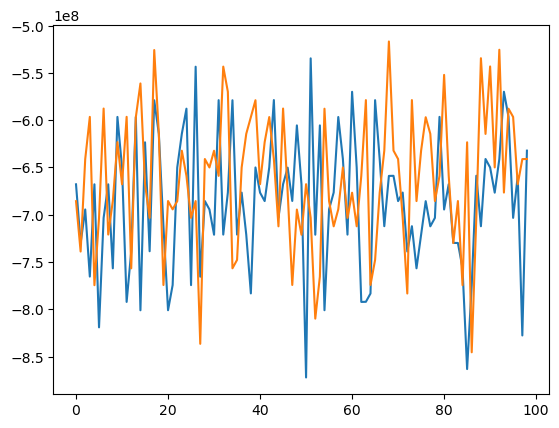

In [24]:
 #learned wala

plt.plot(all_penalties)
plt.plot(all_penalties_rand)

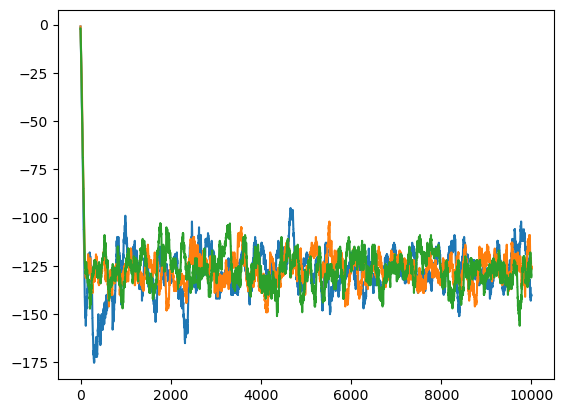

In [11]:
for i in range(3):

    penalties = np.array(all_penalties[i])
    b = penalties.cumsum()
    b[100:] = b[100:]-b[:-100]
    plt.plot(b)


